# Cryosphere model Comparison tool (CmCt) Dynamic Thickness Tool

In [1]:
import numpy as np
import h5py
import os
import xarray as xr
import pyproj
import time
import netCDF4
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.io.shapereader as shpreader
import concurrent.futures

import dh_utils
import gridding_utils
from bilinear_interp import bilinear_interp

## About This Tool

The CmCt Dynamic Thickness Tool compares the user's uploaded ice sheet model(s) to dynamic thickness data from IMAU, GSFC, and/or GEMB observation data. This observation data is a rectangular grid in UTM zone 24N coordinates but the model is expected as a rectangular grid in ISMIP6 polar-stereographic coordinates (see the Input Data Requirements section). The model data is bilinearly interpolated to observation space and the residual is outputted as a netCDF4 file in observation space. 

The model currently uses these three datasets made by CREDIT HERE, and available upon request from ACCESS HERE. These datasets include dynamic thickness anomaly data from balance years 1995 to 2021: `Dynamic_h_Greenland_GEMB_1994_2021.nc`, `Dynamic_h_Greenland_GSFC_1994_2021.nc`, and `Dynamic_h_Greenland_IMAU_1994_2020.nc`. See OBSERVATION DATA DOCUMENTATION HERE for more information about these datasets.

### Multiple Comparisons
This tool uses parallel processing to allow the user to efficiently compare multiple model files with multiple observation files. A comparison can occur between any observation file (of the three listed above) and any model file listed in the `model_fns` input in any balance year for which both have data, or even for a range of years. The user may request any amount of comparisons be done. See the "Desired Comparisons" subsection of the "Input Data Requirements" section for more information.

## Input Data Requirements

### Input netCDF file requirements
The user may include multiple netCDF4 model files, but they must contain these four variables: x, y, time, and dh. 

#### Coordinate System (x and y variables)
Coordinates are defined on a rectangular X-Y grid in the ISMIP6 standard projected polar-stereographic space. The ISMIP6 standard projection is defined [here](https://theghub.org/groups/ismip6/wiki/ISMIP6-Projections-Greenland). This means that in the model netCDF4 file, there must be variables x and y such that x has dimensions (x,) and length A and y has dimensions (y,) and length B. If multiple netCDF4 files are entered as inputs, their x and y variables are assumed to be the same, and behavior of this tool is undefined in the case that they are not. 

#### Time
Must be an array of integers, floats, or strings representing the number of years since AD 0. "1996", 1996.0, and 1996 are all acceptable entries, but no month, day, time-of-day, or timezone information should be provided. The entries of `time` must be in increasing order and consecutive. If multiple netCDF4 files are entered as inputs, their time variables may be different (i.e. one model file may include data from 1996 to 2006, another may include data from 2000 to 2010) as long as they follow these guidelines.

#### Dh variable
The CmCt Grace Mascon tool expects the uploaded model to contain dynamic thickness data (the `dh` variable) for the comparison (should be in units of meters). dh must have dimensions (time, y, x) such that dh\[i,j,k] is the change in dynamic thickness anomaly in meters from Sep 1st, time\[i] to Aug 31st, time\[i] + 1 at the position described by (x\[k], y\[j]) in ISMIP6 polar-stereographic space.


### Desired Comparisons
The filenames of all model files the user wishes to include should be listed in the variable `model_fns` as a list of strings. The input `desired_comparisons` is a list of 4-tuples of the form `(obs_src, idx_mod, start_year, end_year)`. `obs_src` should be either "IMAU", "GEMB" or "GSFC" to indicate the observation dataset. `idx_mod` is an index of `model_fns` to indicate the model dataset. 

`start_year` and `end_year` should be ints representing the start and end year of the comparison. For example, if `start_year` = 1996 and `end_year` = 1997, then the observation change in dynamic thickness anomaly from Sep 1st, 1996 to Aug 31st 1997 will be compared with the modelled change in dynamic thickness anomaly from Sep 1st, 1996 to Aug 31st 1997. Likewise, if `start_year` = 2007 and `end_year` = 2015, then the observation change in dynamic thickness anomaly from Sep 1st, 2007 to Aug 31st 2015 will be compared with the modelled change in dynamic thickness anomaly from Sep 1st, 2007 to Aug 31st 2015. Note that the start and end years cannot occur before the start of observation data collection (1995) or after the end of observation data collection (2021 for GSFC and GEMB, 2020 for IMAU).


### Regridding
The user has the option to regrid the model and observation data to a grid in polar stereographic with their choice of resolution and extent. This is controlled by the `regrid` input variable. If `regrid` is False, then the model data will be interpolated to observation coordinates and subtracted, giving a residual which is in observation space (aka a grid in UTM zone 24N). If `regrid` is True, then the user will have to supply other input variables denoting the extent and resolution of the desired grid in polar-stereographic coordinates. Both model and observation data will be converted to this new grid before being subtracted to give a residual. The method of conversion is the same for model and observation data: all datapoints spatially contained within a certain grid cell will be averaged to give the value for that grid cell.

## Outputs and Plotting

The CmCt offers multiple options for output saving and plotting. 

### Saving
If the input `save_nc` is False, the CmCt will not save any netCDF files. Otherwise, in the case that only one comparison is desired, the CmCt will create a netCDF file (with the filename being the first entry of the `output_fns` list) which has the following variables: x, y, dh_res, and spatial_ref. dh_res will store the residual of the comparison as a grid in UTM zone 24N and will have dimensions (y, x).

In the case that multiple comparisons are desired (and `save_nc` is True), the user has two options controlled by the input variable `single_file_nc`. If `single_file_nc` is False, then each residual will be saved in a netCDF file of the form described above. The comparison described by desired_comparisons\[i] will be saved with the filename output_fn\[i]. 

If `single_file_nc` is True, then all residuals will be stacked and saved in a single netCDF file to the filename output_fns\[0]. This file will have the following variables: x, y, spatial_ref, obs_src, model_id, start_year, end_year, all_dh_res. There is also a "comparison" dimension, which has the same length as desired_comparisons. all_dh_res has the form (comparison, y, x), where all_dh_res\[i,:,:] is the residual for desired_comparison\[i]. obs_src, model_id, start_year, and end_year each have form (comparisons,) and store the observation source (either "IMAU", "GSFC", or "GEMB"), model id (given by the input `model_ids`), start_year, and end_year for each comparison respectively. If the `model_fn_ids` input is None, then the model_id for each model will be the filename given in `model_fn` (this is not recommended).

### Plotting
The `plot` variable is an array of booleans with the same length as `desired_comparisons`, and if `plot`\[i] is True, the observation data, model data, and residual for `desired_comparisons`\[i] will be plotted. The `save_plot` variable is an array of booleans with the same length as `desired_comparisons`, and if `plot`\[i] and `save_plot`\[i] are True, the plot for `desired_comparisons`\[i] will be saved to `plot_fn`\[i].

## Inputs

In [2]:
# Model filenames (see "Desired Comparisons" subsection above for more info)
n = 7
model_fns = ["/home/jovyan/shared-public/CmCt/models/ensemble/gris.proj.2007-2015.A1" 
             + (str(i)).zfill(3) + ".dhdynAnom6079.nc" for i in range(n)]


# Desired comparisons (see "Desired Comparisons" subsection above for more info)
desired_comparisons = [("IMAU", i, 2007, 2015) for i in range(n)]

# Initialize optional preference variables to None
single_file_nc, save_plot, plot_fn, output_fns, model_fn_ids, extent, grid_size = None, None, None, None, None, None, None

regrid = True
if regrid:
    extent = np.array([-720500.0, 960500.0, -3450500.0, -569500.0])  # Left, right, top, bottom in polar stereographic
    grid_size = 50000.   # Units of meters in polar stereographic

# Plotting and Saving Preferences
save_nc = False
if save_nc:   single_file_nc = True
plot = np.ones((n,)).astype('bool')
if np.sum(plot):      save_plot = np.zeros((n,)).astype('bool')


# Plotting and Saving Needed Information
if save_nc:
    output_fns = ["output_files/res_A1" + (str(i)).zfill(3) + ".nc" for i in range(n)]

    if single_file_nc:
        model_fn_ids = ["A1" + (str(i)).zfill(3) for i in range(n)]

if np.sum(plot):
    if np.sum(save_plot):
        plot_fn = ["output_files/plot" + model_fn_ids[i] + ".png" for i in range(n)]


# Check the validity of inputs; error is a boolean
global error
error = dh_utils.check_input_validity(save_nc, output_fns, single_file_nc, len(desired_comparisons), 
                                      model_fn_ids, len(model_fns), plot, save_plot, plot_fn, 
                                     regrid, extent, grid_size)

## Read in Observation Data

In [3]:
def read_obs_file(desired_comparisons):
    global x_UTM
    global y_UTM
    global crs_wkt

    obs_paths = {"IMAU": "observation_data/Dynamic_h_Greenland_IMAU_1994_2020.nc", 
                 "GEMB": "observation_data/Dynamic_h_Greenland_GEMB_1994_2021.nc",
                 "GSFC": "observation_data/Dynamic_h_Greenland_GSFC_1994_2021.nc"}

    # Outputs. For a more complete description, see the runProcessing function
    all_dh_obs = []      # list of 2D arrays
    comp_2_obs_idx = np.empty((len(desired_comparisons),), dtype = "int")

    # Interpret the list of tuples into a format that prevents duplicating data
    comp_info = dh_utils.manage_comparisons(desired_comparisons, True)

    set_common_vars = False
    for src in comp_info:
        # Read in file info
        fn = obs_paths[src]
        with h5py.File(fn, mode='r') as f:
            if not set_common_vars:        # Ensures this is only done once, not three times
                x_UTM = f['x'][:]
                y_UTM = f['y'][:]
                spatial_ref = f['spatial_ref']
                crs_wkt = spatial_ref.attrs['crs_wkt'].decode('UTF-8')   # Contains coordinate system data
                set_common_vars = True

            time_obs = (f['time'][:]).astype("int")
            dh = f['dh'][:]    # Has shape (len(time_obs), len(y_UTM), len(x_UTM))


        # Select only years of dh data needed for some comparison; construct outputs
        for start_year, end_year in comp_info[src]:
            start_bal_year, end_bal_year = start_year, end_year - 1

            # Check that both years are within the bounds of observation
            if not (dh_utils.time_within_bounds(start_bal_year, time_obs, "Desired start year", "observation data")
                        & dh_utils.time_within_bounds(end_bal_year, time_obs, "Desired end year", "observation data")):
                return None, None

            # Compute the total change over this timescale
            time_idx_start = np.argwhere(time_obs == start_bal_year)[0,0]
            time_idx_end = np.argwhere(time_obs == end_bal_year)[0,0]
            dh_obs = np.sum(dh[time_idx_start:(time_idx_end + 1), :, :], axis = 0)

            # Append to all_dh_obs and update comp_2_obs_idx
            all_dh_obs.append(dh_obs)
            obs_idx = len(all_dh_obs) - 1
            for i in (comp_info[src])[(start_year, end_year)]:
                comp_2_obs_idx[i] = obs_idx
        dh = None   # De-allocate memory
        
    return all_dh_obs, comp_2_obs_idx

## Read in Model Data

In [4]:
def read_model_file(model_fns, desired_comparisons):
    global x_mod
    global y_mod

    # Outputs. For a more complete description, see the runProcessing function
    all_dh_mod = []
    comp_2_mod_idx = np.empty((len(desired_comparisons),), dtype = "int")

    # Interpret the list of tuples into a format that prevents duplicating data
    comp_info = dh_utils.manage_comparisons(desired_comparisons, False)
    
    set_common_vars = False
    for idx_mod in comp_info:     # Iterate over model files
        # Read file data
        fn = model_fns[idx_mod]
        with h5py.File(fn , mode='r') as f:
            if not set_common_vars:
                # See "Input Data Requirements" section for more details on the format of these variables
                x_mod = f['x'][:]
                y_mod = f['y'][:]
                set_common_vars = True

            time_mod = (f['t'][:]).astype("int")
            dh = f['dh_dynAnom'][:]   #dh = f['dh_dynAnom'][:]


        # Select only years of dh data needed for some comparison; construct outputs
        for start_year, end_year in comp_info[idx_mod]:
            start_bal_year, end_bal_year = start_year, end_year - 1

            # Check that both years are within the bounds of observation
            if not (dh_utils.time_within_bounds(start_bal_year, time_mod, "Desired start year", "model data")
                        & dh_utils.time_within_bounds(end_bal_year, time_mod, "Desired end year", "model data")):
                return None, None

            # Compute the total change over this timescale
            time_idx_start = np.argwhere(time_mod == start_bal_year)[0,0]
            time_idx_end = np.argwhere(time_mod == end_bal_year)[0,0]
            dh_mod = np.sum(dh[time_idx_start:(time_idx_end + 1), :, :], axis = 0)

            # Append to all_dh_mod and update comp_2_mod_idx
            all_dh_mod.append(dh_mod)
            mod_idx = len(all_dh_mod) - 1
            for i in (comp_info[idx_mod])[(start_year, end_year)]:
                comp_2_mod_idx[i] = mod_idx
                
        dh = None   # De-allocate memory
            
    return all_dh_mod, comp_2_mod_idx

## Transform Observation Coordinates from UTM-24N to ISMIP6 polar-stereographic coordinates

In [5]:
def transform_UTM_grid_to_list_of_polar_stereo_points(crs_wkt, x_UTM, y_UTM):
    # See "About This Tool" section for observation coordinate system information
    
    # Make a transformer from observation coordinates to model coordinates
    crs_utm = pyproj.crs.CRS.from_wkt(crs_wkt)    # Coordinate system of observation data
    crs_ps = gridding_utils.crs_ps()
    utm_to_ps = pyproj.Transformer.from_crs(crs_from = crs_utm, crs_to = crs_ps)

    # Format observation coordinate data into two 1D arrays of the same length
    x_UTM_points, y_UTM_points = gridding_utils.flatten_to_list_of_points(x_UTM, y_UTM)

    # Transform observation coordinate points to points in polar-stereographic space
    x_obs, y_obs = utm_to_ps.transform(x_UTM_points, y_UTM_points)
    return x_obs, y_obs

## Interpolate Model to Observation Space

In [6]:
def interpolate_all_models_to_observation_space(x_obs, y_obs, dh_obs, all_dh_mod):
    """
    Wrapper function for interp_one_model_to_obs_space which parallelizes the interpolation operation of all models
    """
    
    # Set inputs to interp_one_model_to_obs_space that will not vary between calls
    global I_
    global x_query, y_query     # Interpolation query points (does not include points which are NaN in observation data)
    global newshape             # Shape that the model will be interpolated to
    
    I_ = (~np.isnan(dh_obs)).transpose().flatten()   # I_[i] is False if x_obs[i], y_obs[i] correspond to a point where dh_obs is NaN, True otherwise
    x_query, y_query = x_obs[I_], y_obs[I_]
    newshape = dh_obs.shape

    # Parallelize the interpolation and reshaping step in order to speed up
    if len(all_dh_mod) == 1:
        return [interp_one_model_to_obs_space(all_dh_mod[0])]
    else:
        with concurrent.futures.ProcessPoolExecutor() as executor:
            generator = executor.map(interp_one_model_to_obs_space, all_dh_mod)
            
        all_dh_mod_interped = []
        for dh_mod_interped in generator:
            all_dh_mod_interped.append(dh_mod_interped)
        return all_dh_mod_interped

In [7]:
def interp_one_model_to_obs_space(dh_mod):
    """
    Interpolates a model dh 2D array to observation space and reshape to newshape
    """
    
    # Bilinearly interpolate model to observation space
    model_dh_interped_flat = bilinear_interp(x_mod, y_mod, dh_mod, x_query, y_query)

    # Reshape model array to the same shape as the observation array
    dh_mod_interped = np.empty_like(I_, dtype = np.float64)
    dh_mod_interped[~I_] = np.nan     # Fill with NaN at indices where dh_obs is NaN
    dh_mod_interped[I_] = model_dh_interped_flat
    dh_mod_interped = np.reshape(dh_mod_interped, newshape, order = "F")
    return dh_mod_interped

## Subtract Model and Residual

In [8]:
def compute_residuals(all_dh_obs, comp_2_obs_idx, all_dh_mod_interped, comp_2_mod_idx):
    """
    For each comparison in desired_comparisons, computes the residual and outputs all residuals
    as a list such that all_dh_res[i] corresponds to desired_comparison[i]

    See runProcessing function for details on the inputs to this function
    """
    all_dh_res = []
    for i in range(len(comp_2_obs_idx)):
        obs_idx = comp_2_obs_idx[i]
        mod_idx = comp_2_mod_idx[i]
        all_dh_res.append(all_dh_mod_interped[mod_idx] - all_dh_obs[obs_idx])  # residual = model - observation
    return all_dh_res

## Plot Observation, Model, and Residual

In [9]:
def plot_obs_mod_res(extent, dh_obs, dh_mod_interped, dh_res, year, save_plot, plot_fn):
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['figure.dpi'] = 100
    fig = plt.figure(figsize=(24,14))

    """
    mins = [np.nanmin(dh_obs), np.nanmin(dh_mod_interped), np.nanmin(dh_res)]
    min = np.nanmin(mins)
    maxs = [np.nanmax(dh_obs), np.nanmax(dh_mod_interped), np.nanmax(dh_res)]
    max = np.nanmax(maxs)
    """
    # TEMPORARY!!!! HARD-CODED IN
    min = -25
    max = 25

    # Observation
    ax1 = plt.subplot(131)
    im1 = ax1.imshow(dh_obs, aspect = "equal", origin = "lower", extent = extent, vmin = min, vmax = max, cmap = "RdYlBu")
    ax1.set_xbound(lower = extent[0], upper = extent[1])
    ax1.set_ybound(lower = extent[2], upper = extent[3])
    ax1.set_xlim(left = extent[0], right = extent[1])
    ax1.set_ylim(bottom = extent[2], top = extent[3])
    ax1.set_title(f"Observed", fontsize = 18)
    
    
    # Model
    ax2 = plt.subplot(132)
    im2 = ax2.imshow(dh_mod_interped, aspect = "equal", origin = "lower", extent = extent, vmin = min, vmax = max, cmap = "RdYlBu")
    ax2.set_xbound(lower = extent[0], upper = extent[1])
    ax2.set_ybound(lower = extent[2], upper = extent[3])
    ax2.set_xlim(left = extent[0], right = extent[1])
    ax2.set_ylim(bottom = extent[2], top = extent[3])
    ax2.set_title(f"Modelled (interpolated)", fontsize = 18)
    

    # Residual
    ax3 = plt.subplot(133)
    im3 = ax3.imshow(dh_res, aspect = "equal", origin = "lower", extent = extent, vmin = min, vmax = max, cmap = "RdYlBu")
    ax3.set_xbound(lower = extent[0], upper = extent[1])
    ax3.set_ybound(lower = extent[2], upper = extent[3])
    ax3.set_xlim(left = extent[0], right = extent[1])
    ax3.set_ylim(bottom = extent[2], top = extent[3])
    ax3.set_title(f"Residual (Model - Observation)", fontsize = 18)
    
    # Add shared colorbar
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.875, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax)
    fig.colorbar(im2, cax=cbar_ax)
    fig.colorbar(im3, cax=cbar_ax)
    cbar_ax.set_ylabel("meters", fontsize = 16)
    fig.suptitle("Dynamic Thickness Anomaly Change " + str(year), fontsize = 24)

    if save_plot:
        plt.savefig(plot_fn)
    plt.show()

## Compute Comparison

In [10]:
def runProcessing():
    """
    Before reading, see the "Desired Comparisons" subsection of the "Input Data Requirements" section.

    Here is a summary of what the tool does at a basic level. First it reads in the model and 
    observation data for the appropriate years. It then transforms the spatial coordinates of the 
    observation data from a grid in UTM-24N to a set of non-gridded points in polar-stereographic
    coordinates. Then, using the fact that the model data is a grid in polar-stereographic, the tool
    uses bilinear interpolation to estimate the value of the model data at the locations of the 
    observation data. This and the observation data are then subtracted, giving the residual. Below 
    is a more detailed account of the pipeline, which defines the behavior of important variables.

    Pipeline:
    1) Read in observation data as a list of 2D arrays called all_dh_obs. Each entry of all_dh_obs has
       the same shape, let this be (ny, nx). Each entry of all_dh_obs is for a different year/year-range
       or source necessary in some comparison in desired_comparisons. The variable comp_2_obs_idx records 
       which comparisons need which entry of all_dh_obs: comp_2_obs_idx[i] is the index of all_dh_obs which 
       holds the observation data needed for desired_comparison[i]. The spatial information for all 
       observation data arrays is stored in x_UTM and y_UTM, and x_UTM has length nx and y_UTM has 
       length ny.
    2) Read in model data as a list of 2D arrays called all_dh_mod. Each entry of all_dh_mod is assumed 
       to have the same shape. Each entry of all_dh_mod is for a different year/year range or model 
       necessary in some comparison in desired_comparisons. The variable comp_2_mod_idx records which 
       comparisons need which entry of all_dh_mod: comp_2_mod_idx[i] is the index of all_dh_mod which holds 
       the model data needed for desired_comparison[i]. The spatial information for all model data arrays 
       is stored in x_mod and y_mod. See the "Coordinate System" subsection of the "Input Data Requirements" 
       section for more information.
    3) Reshape coordinate information encoded in x_UTM and y_UTM to a set of points described by two 1D 
       arrays (both with length nx * ny), which are then converted into polar stereographic coordinates. 
       These arrays are x_obs and y_obs.
    4) If regrid = True, regrid all entries of all_dh_obs and all_dh_mod to the desired grid, then subtract.
       Otherwise, for each entry of all_dh_mod, bilinearly interpolate from the model's grid in polar stereographic, 
       using x_obs and y_obs as the query points. This will return an estimated value of the modelled 
       value at each of the points for which the observation value is known. In other words, the model has 
       been brought to observation space. Note that this step is done in parallel.
    5) For each desired comparison, compute the residual (model - observation) in observation space
    6) (Optional) Write all residuals to netCDF4 files
    7) (Optional) For a single comparison, plot the observation, model, and residual and optionally save 
        the plot
    """
    
    if error:
        return None
    
    update_progress(0.0, "Starting...              ", 0.0)
    t = time.time()
    all_dh_obs, comp_2_obs_idx = read_obs_file(desired_comparisons)     # Sets global variables x_UTM, y_UTM, crs_wkt
    if all_dh_obs is None:
        return None
    update_progress(0.2, "Read Observation Data    ", time.time() - t)

    
    t = time.time()
    all_dh_mod, comp_2_mod_idx = read_model_file(model_fns, desired_comparisons)     # Sets global variables x_mod, y_mod
    if all_dh_mod is None:
        return None
    update_progress(0.4, "Read Model Data          ", time.time() - t)

    t = time.time()
    x_obs, y_obs,  = transform_UTM_grid_to_list_of_polar_stereo_points(crs_wkt, x_UTM, y_UTM)
    update_progress(0.5, "Transformed Coordinates  ", time.time() - t)

    t = time.time()
    if regrid:
        # Construct grid
        x_centers, y_centers = gridding_utils.grid_centers_from_extent_and_res(extent, grid_size)

        # Regrid observation and model
        all_dh_obs = gridding_utils.regrid_data(x_centers, y_centers, x_obs, y_obs, [dh_obs.transpose().flatten() for dh_obs in all_dh_obs])
        x_mod_flat, y_mod_flat = gridding_utils.flatten_to_list_of_points(x_mod, y_mod)
        all_dh_mod_interped = gridding_utils.regrid_data(x_centers, y_centers, x_mod_flat, y_mod_flat, [dh_mod.transpose().flatten() for dh_mod in all_dh_mod])
    else:
        all_dh_mod_interped = interpolate_all_models_to_observation_space(x_obs, y_obs, all_dh_obs[0], all_dh_mod)
    all_dh_mod = None    # Deallocate memory
    update_progress(0.7, "Interpolated Model       ", time.time() - t)
    

    t = time.time()
    all_dh_res = compute_residuals(all_dh_obs, comp_2_obs_idx, all_dh_mod_interped, comp_2_mod_idx)
    update_progress(0.8, "Computed Residuals       ", time.time() - t)

    
    if save_nc:
        t = time.time()
        if regrid:
            dh_utils.save_residuals_to_netcdf(output_fns, all_dh_res, x_centers, y_centers, desired_comparisons, 
                                              gridding_utils.crs_ps().to_wkt(), single_file_nc, model_fn_ids)
        else:
            dh_utils.save_residuals_to_netcdf(output_fns, all_dh_res, x_UTM, y_UTM, desired_comparisons, crs_wkt,
                                          single_file_nc, model_fn_ids)
        update_progress(0.9, "Saved residuals to NetCDF", time.time() - t)
    
    if np.sum(plot) > 0:
        print("Plotting....")
        t = time.time()
        for i, b in enumerate(plot):
            if b & regrid: 
                plot_obs_mod_res((x_centers[0], x_centers[-1], y_centers[0], y_centers[-1]), all_dh_obs[comp_2_obs_idx[i]], 
                         all_dh_mod_interped[comp_2_mod_idx[i]], all_dh_res[i], (desired_comparisons[i])[2], 
                         save_plot[i], plot_fn[i] if save_plot[i] else None)
            elif b & (not regrid): 
                plot_obs_mod_res((x_UTM[0], x_UTM[-1], y_UTM[0], y_UTM[-1]), all_dh_obs[comp_2_obs_idx[i]], 
                         all_dh_mod_interped[comp_2_mod_idx[i]], all_dh_res[i], (desired_comparisons[i])[2], 
                         save_plot[i], plot_fn[i] if save_plot[i] else None)
        update_progress(1.0, "Plotted Results          ", time.time() - t)
    
    print("Success")
    return "Success"

In [11]:
# update processing progress bar
def update_progress(progress, title, time_elapsed_print):
    bar_length = 20
    block = int(20.0*progress)
    text = title+" [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100) + f" ({time_elapsed_print} seconds)"
    print(text)   

Starting...               [--------------------] 0.0% (0.0 seconds)
Read Observation Data     [####----------------] 20.0% (2.293239116668701 seconds)
Read Model Data           [########------------] 40.0% (4.043306112289429 seconds)
Transformed Coordinates   [##########----------] 50.0% (1.2040772438049316 seconds)
Interpolated Model        [##############------] 70.0% (2.598594903945923 seconds)
Computed Residuals        [################----] 80.0% (0.00023055076599121094 seconds)
Plotting....


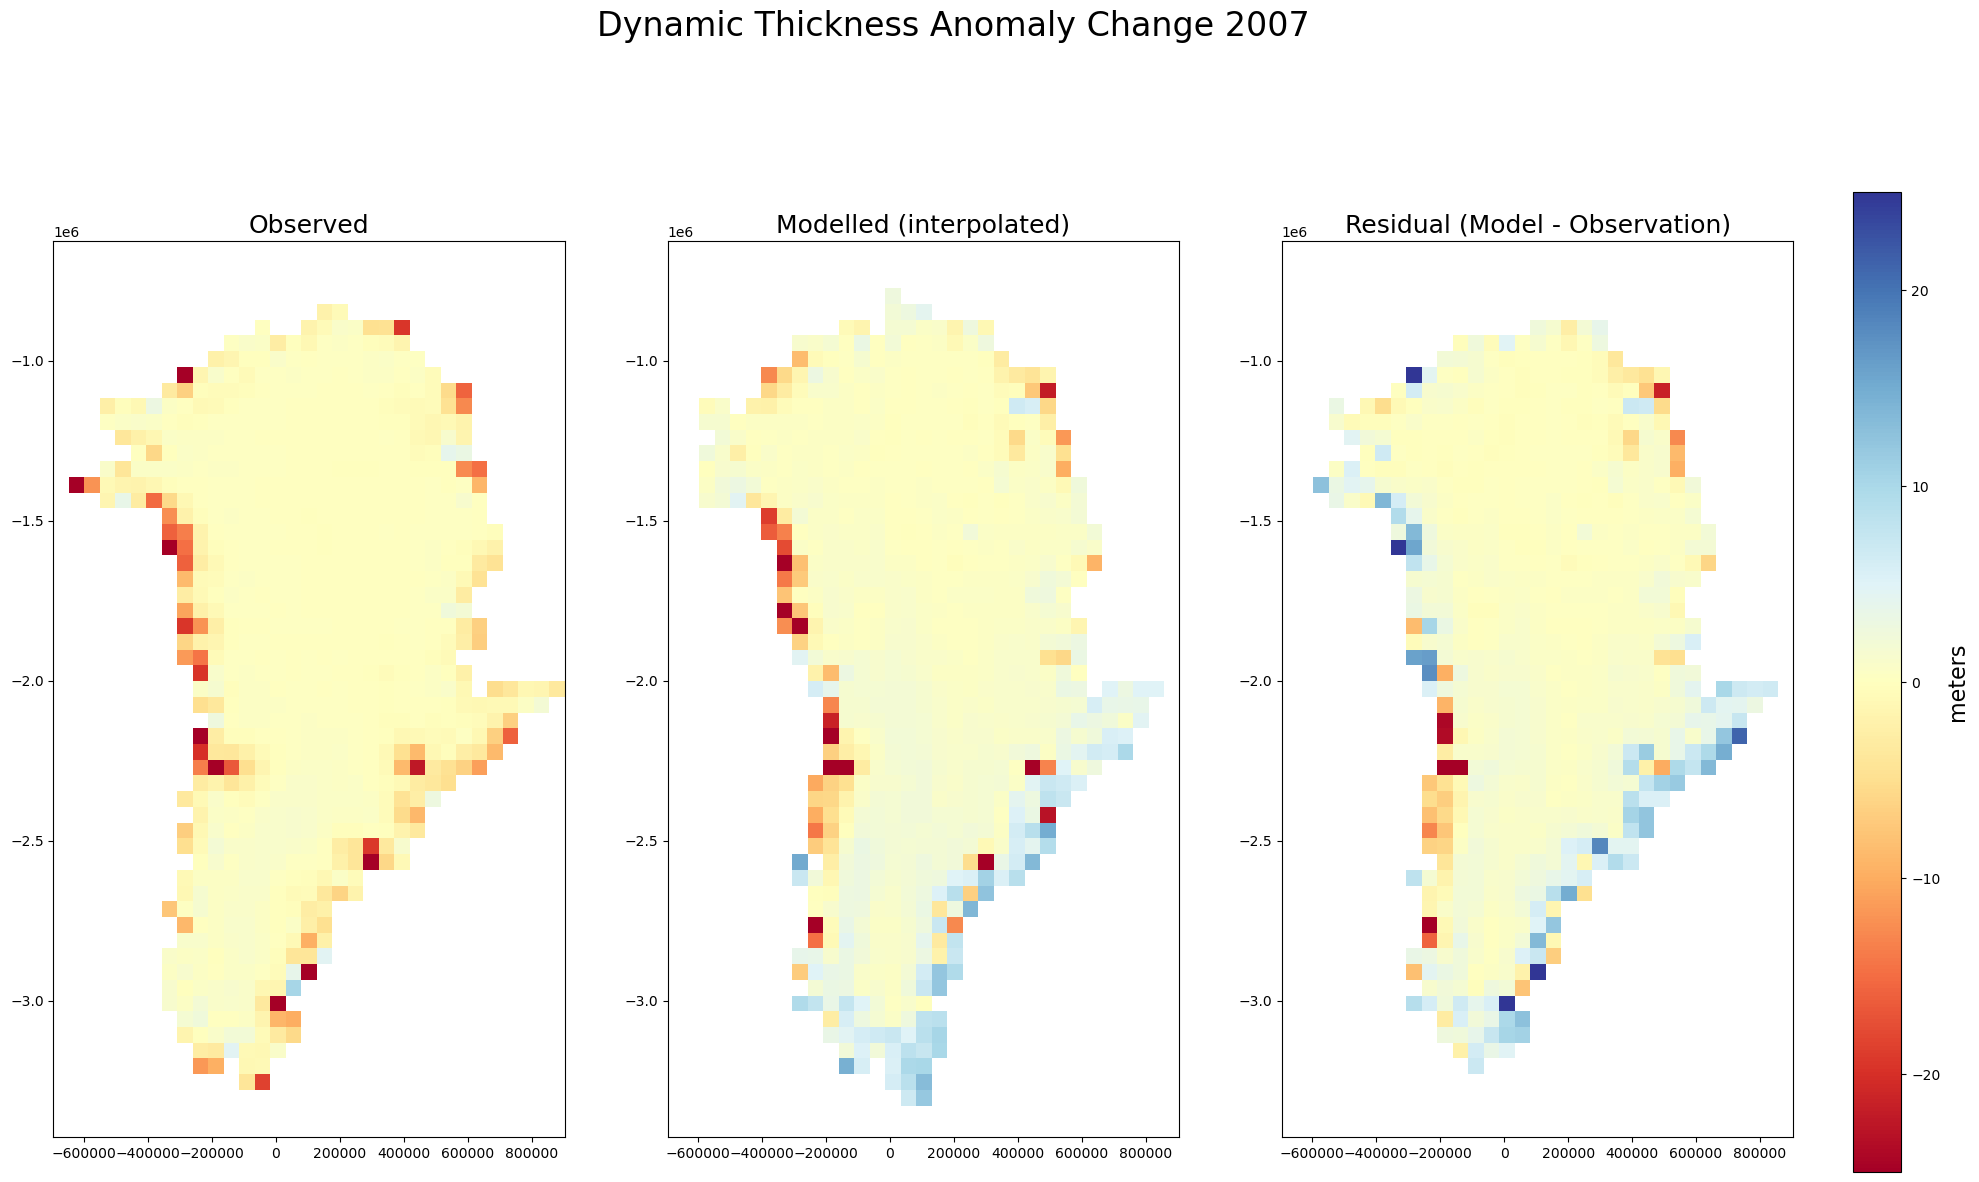

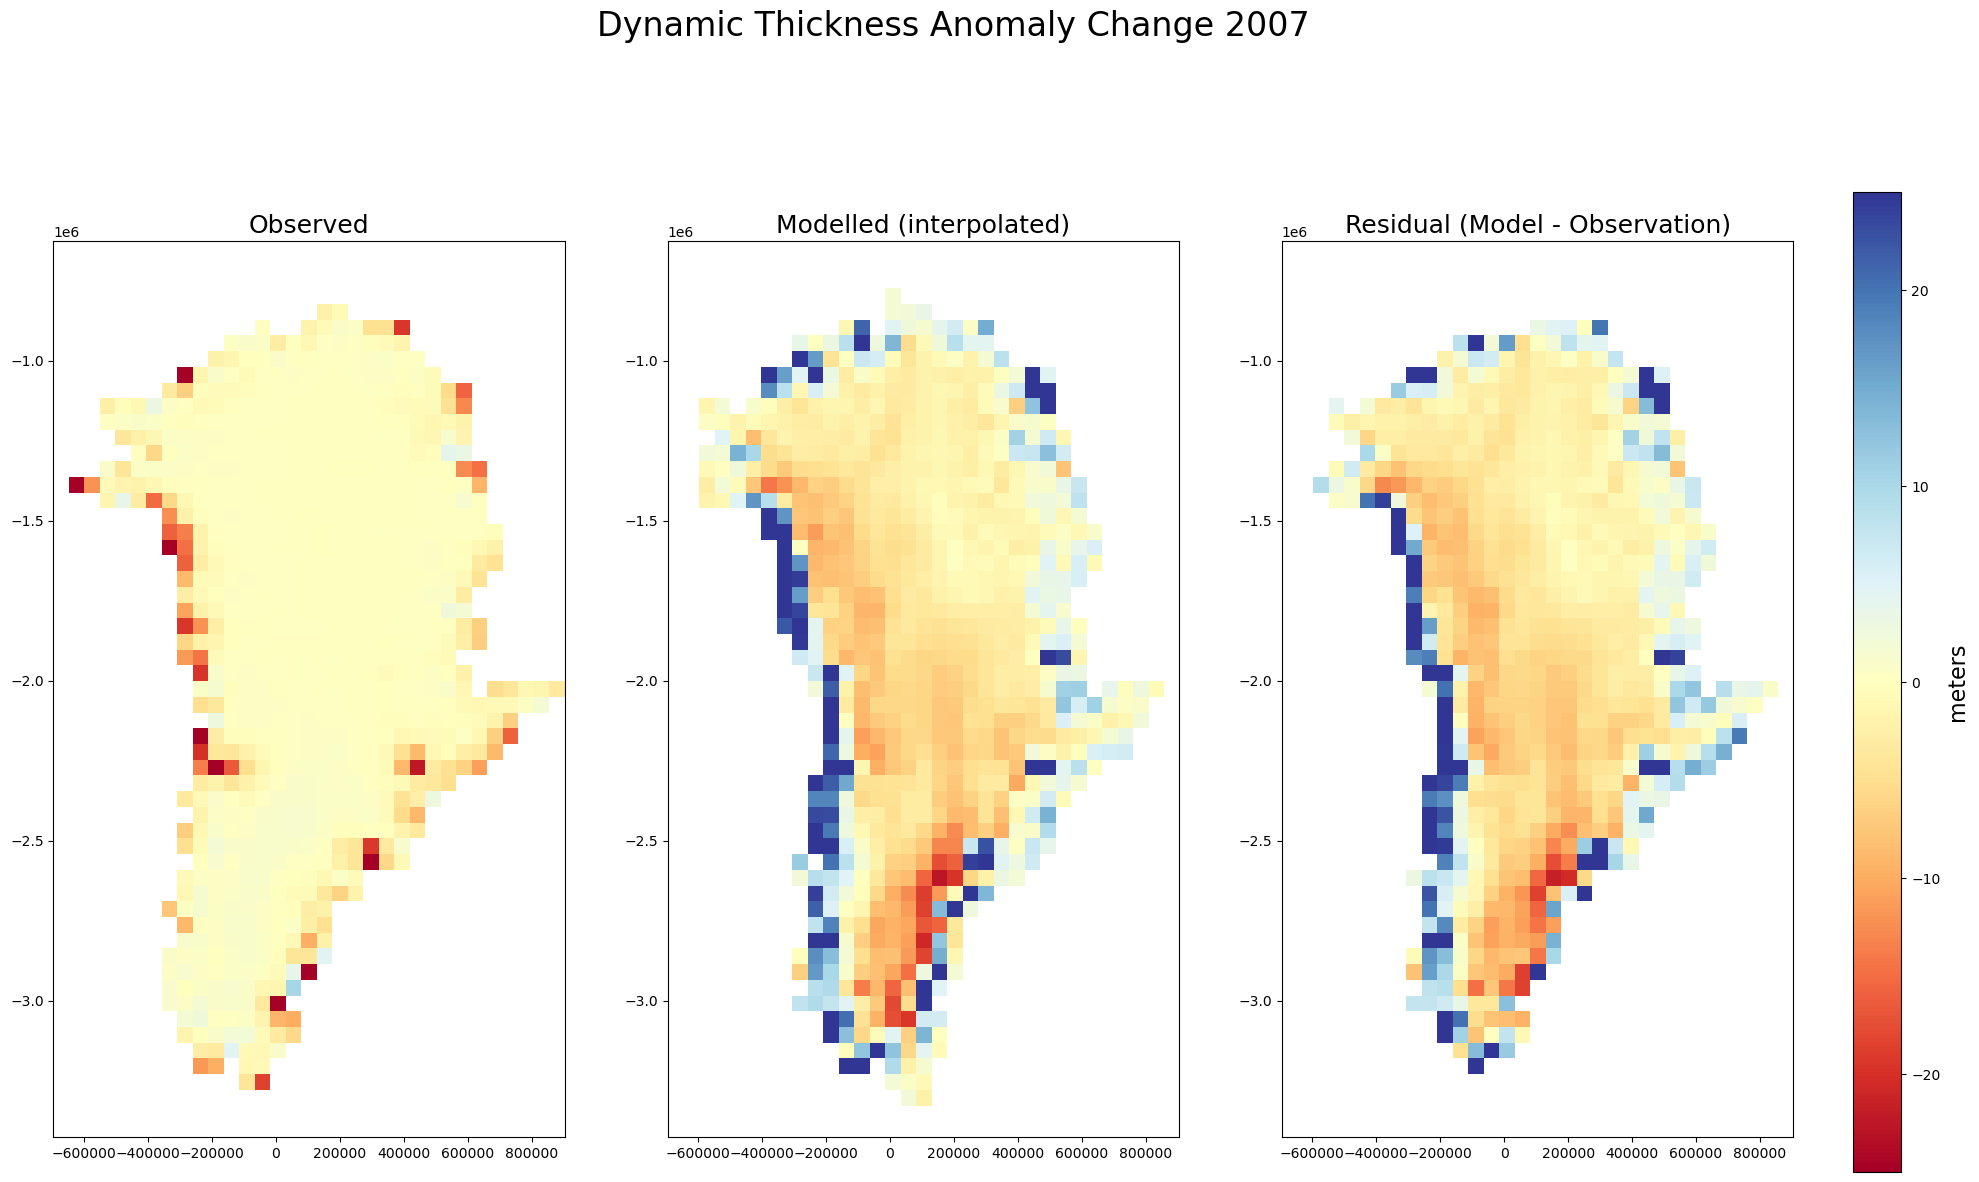

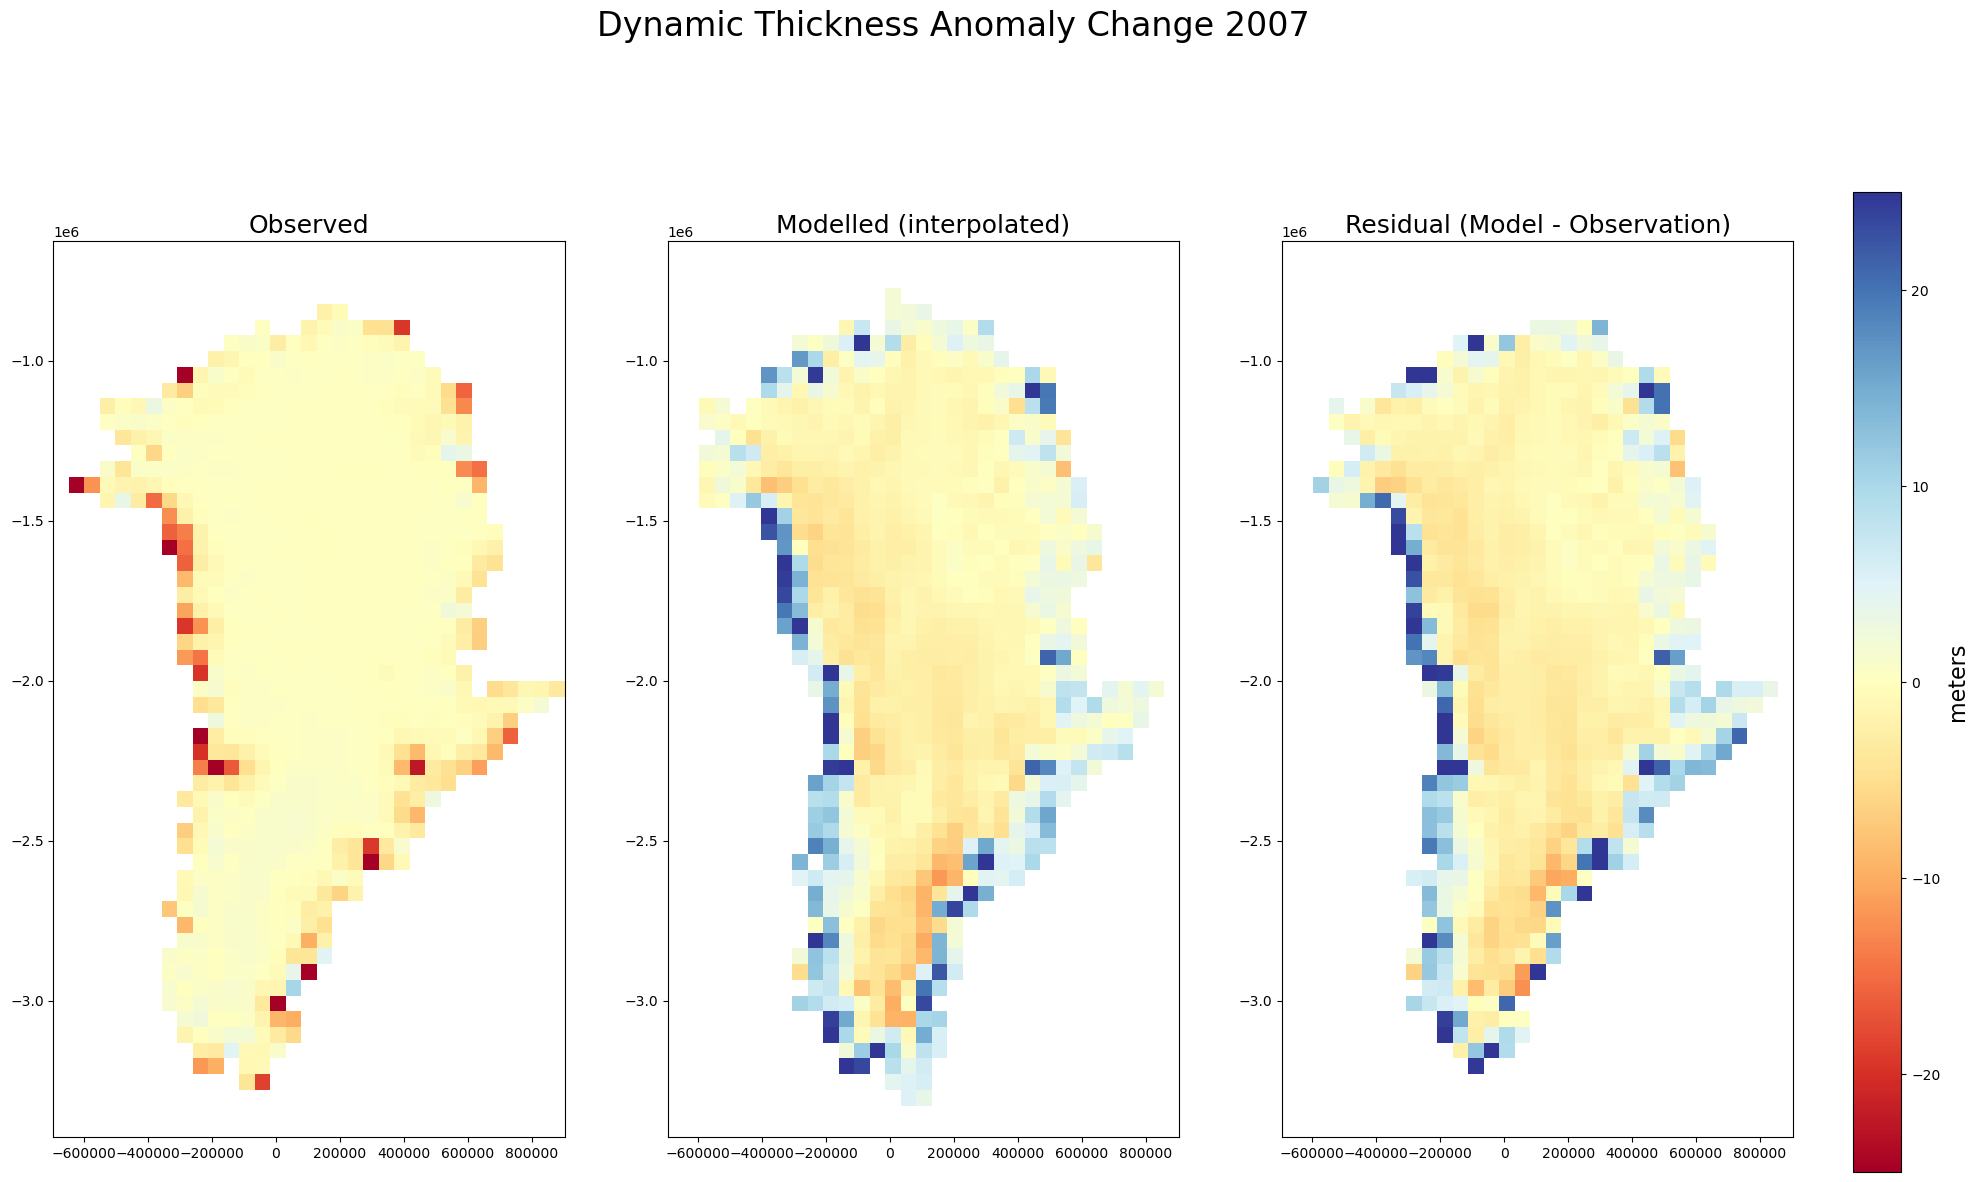

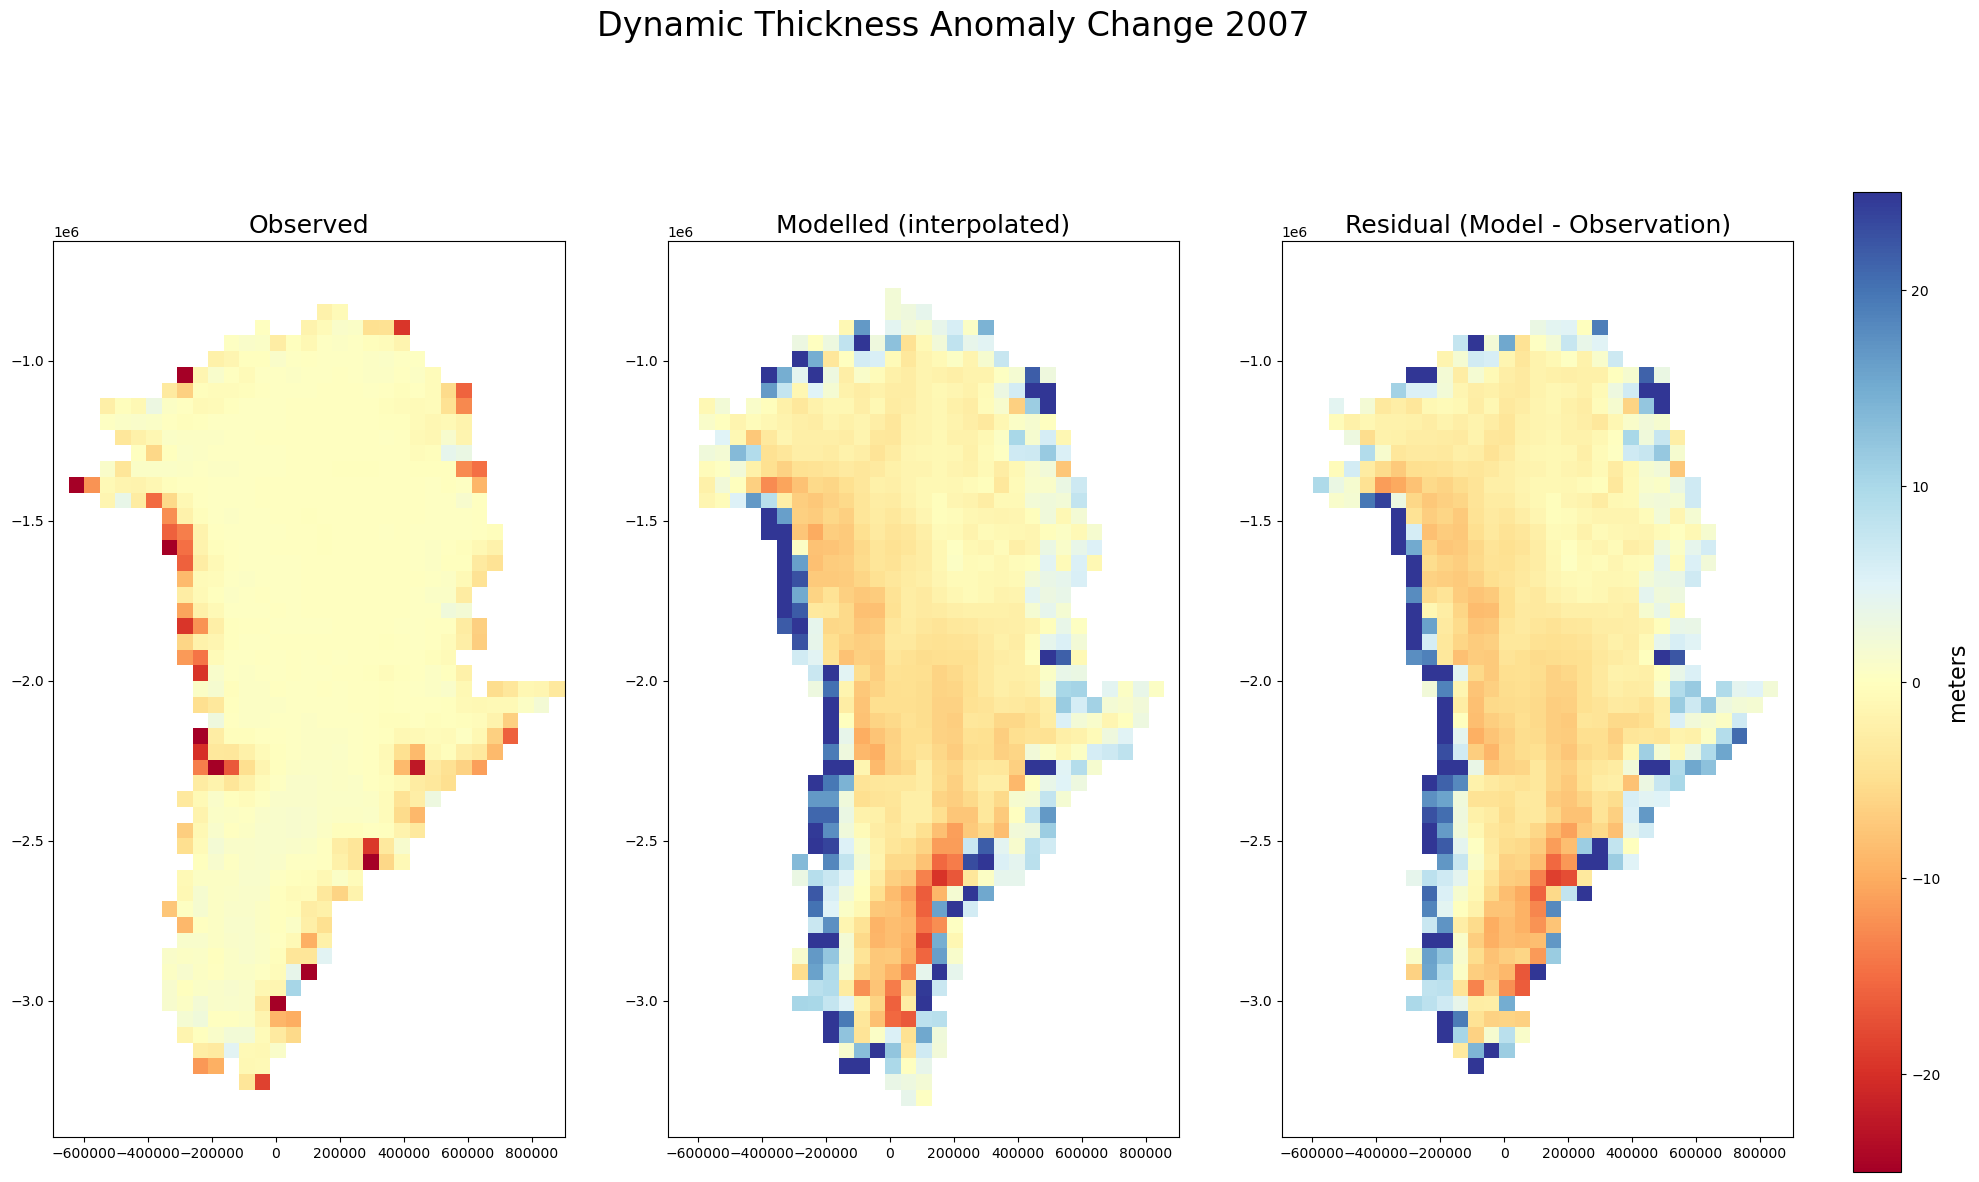

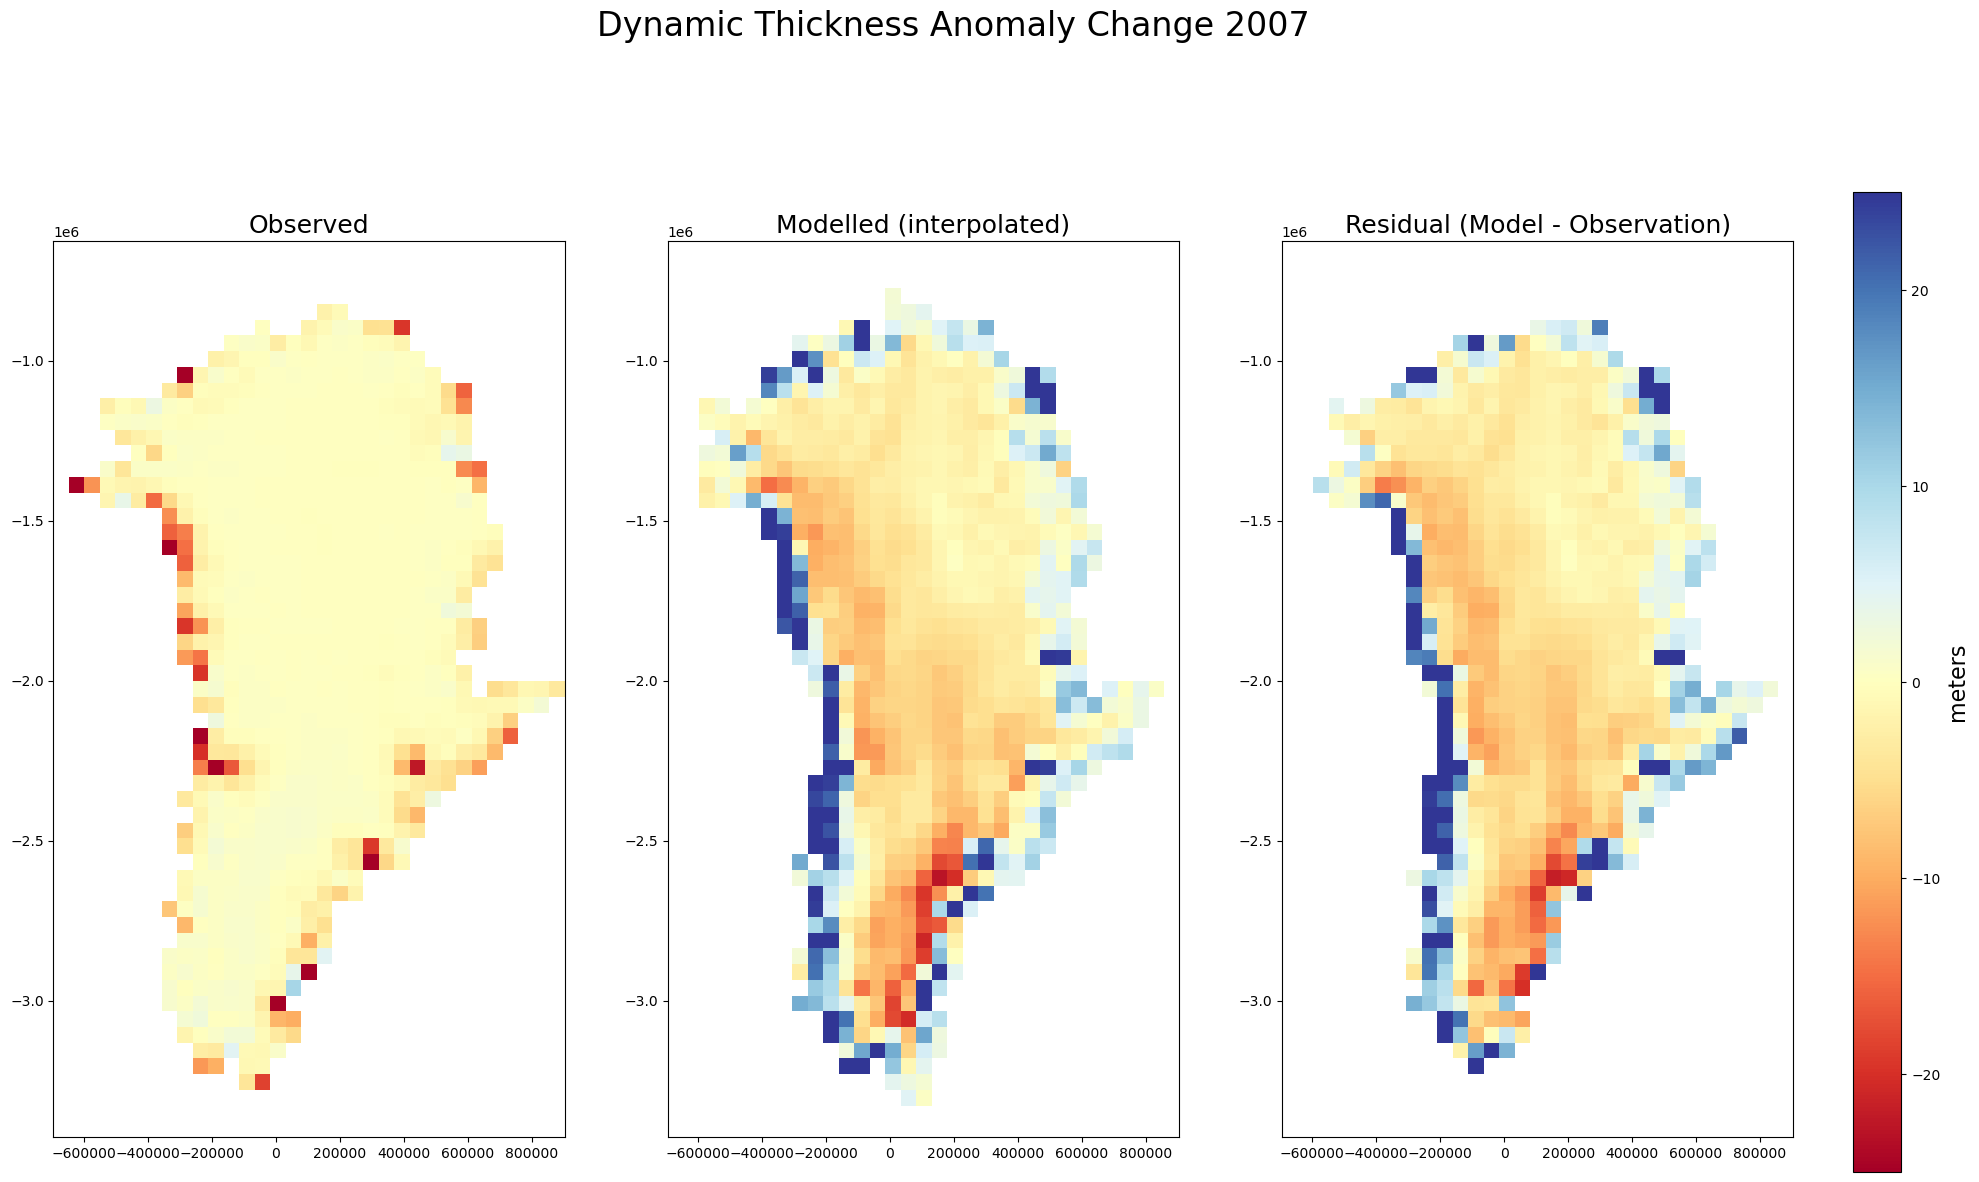

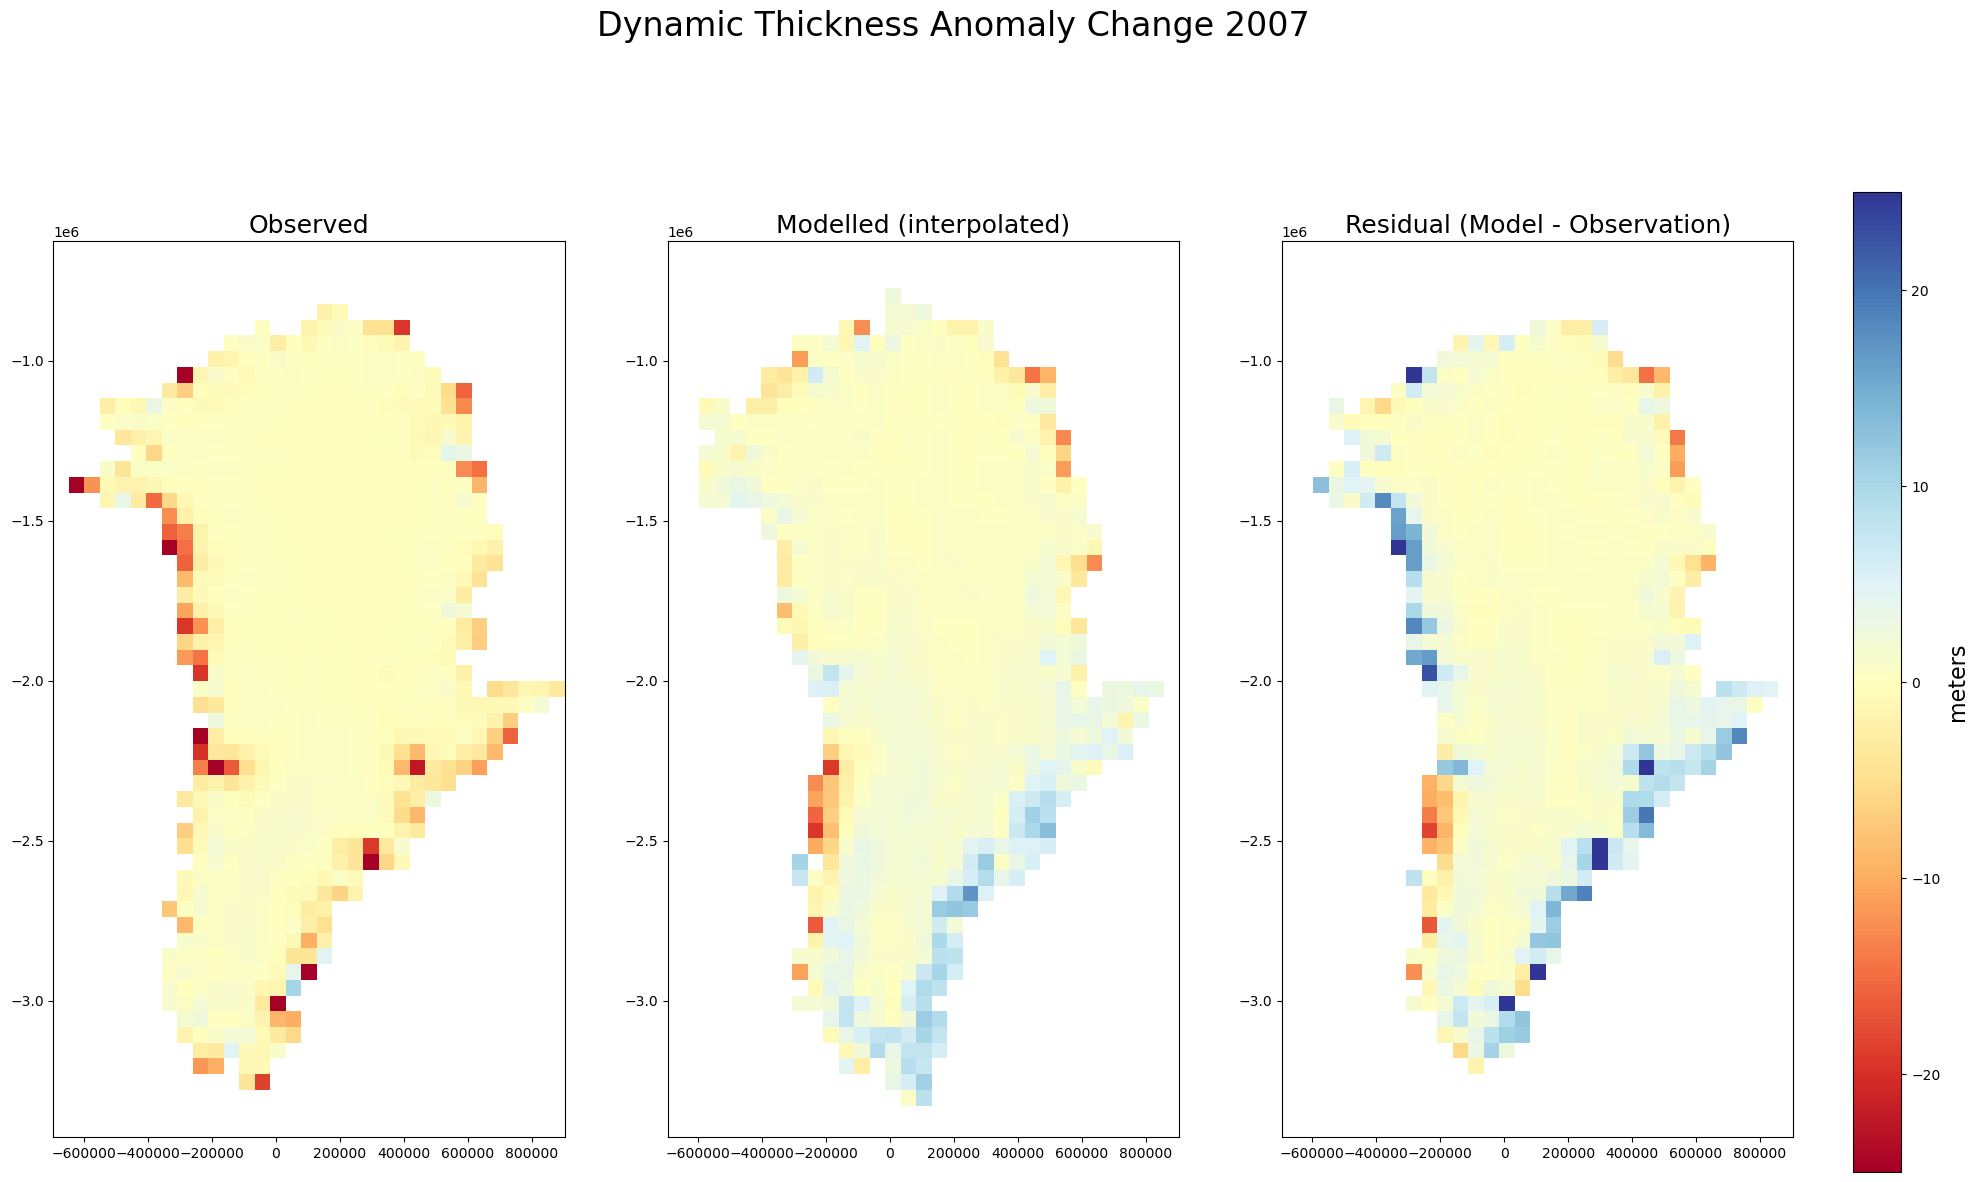

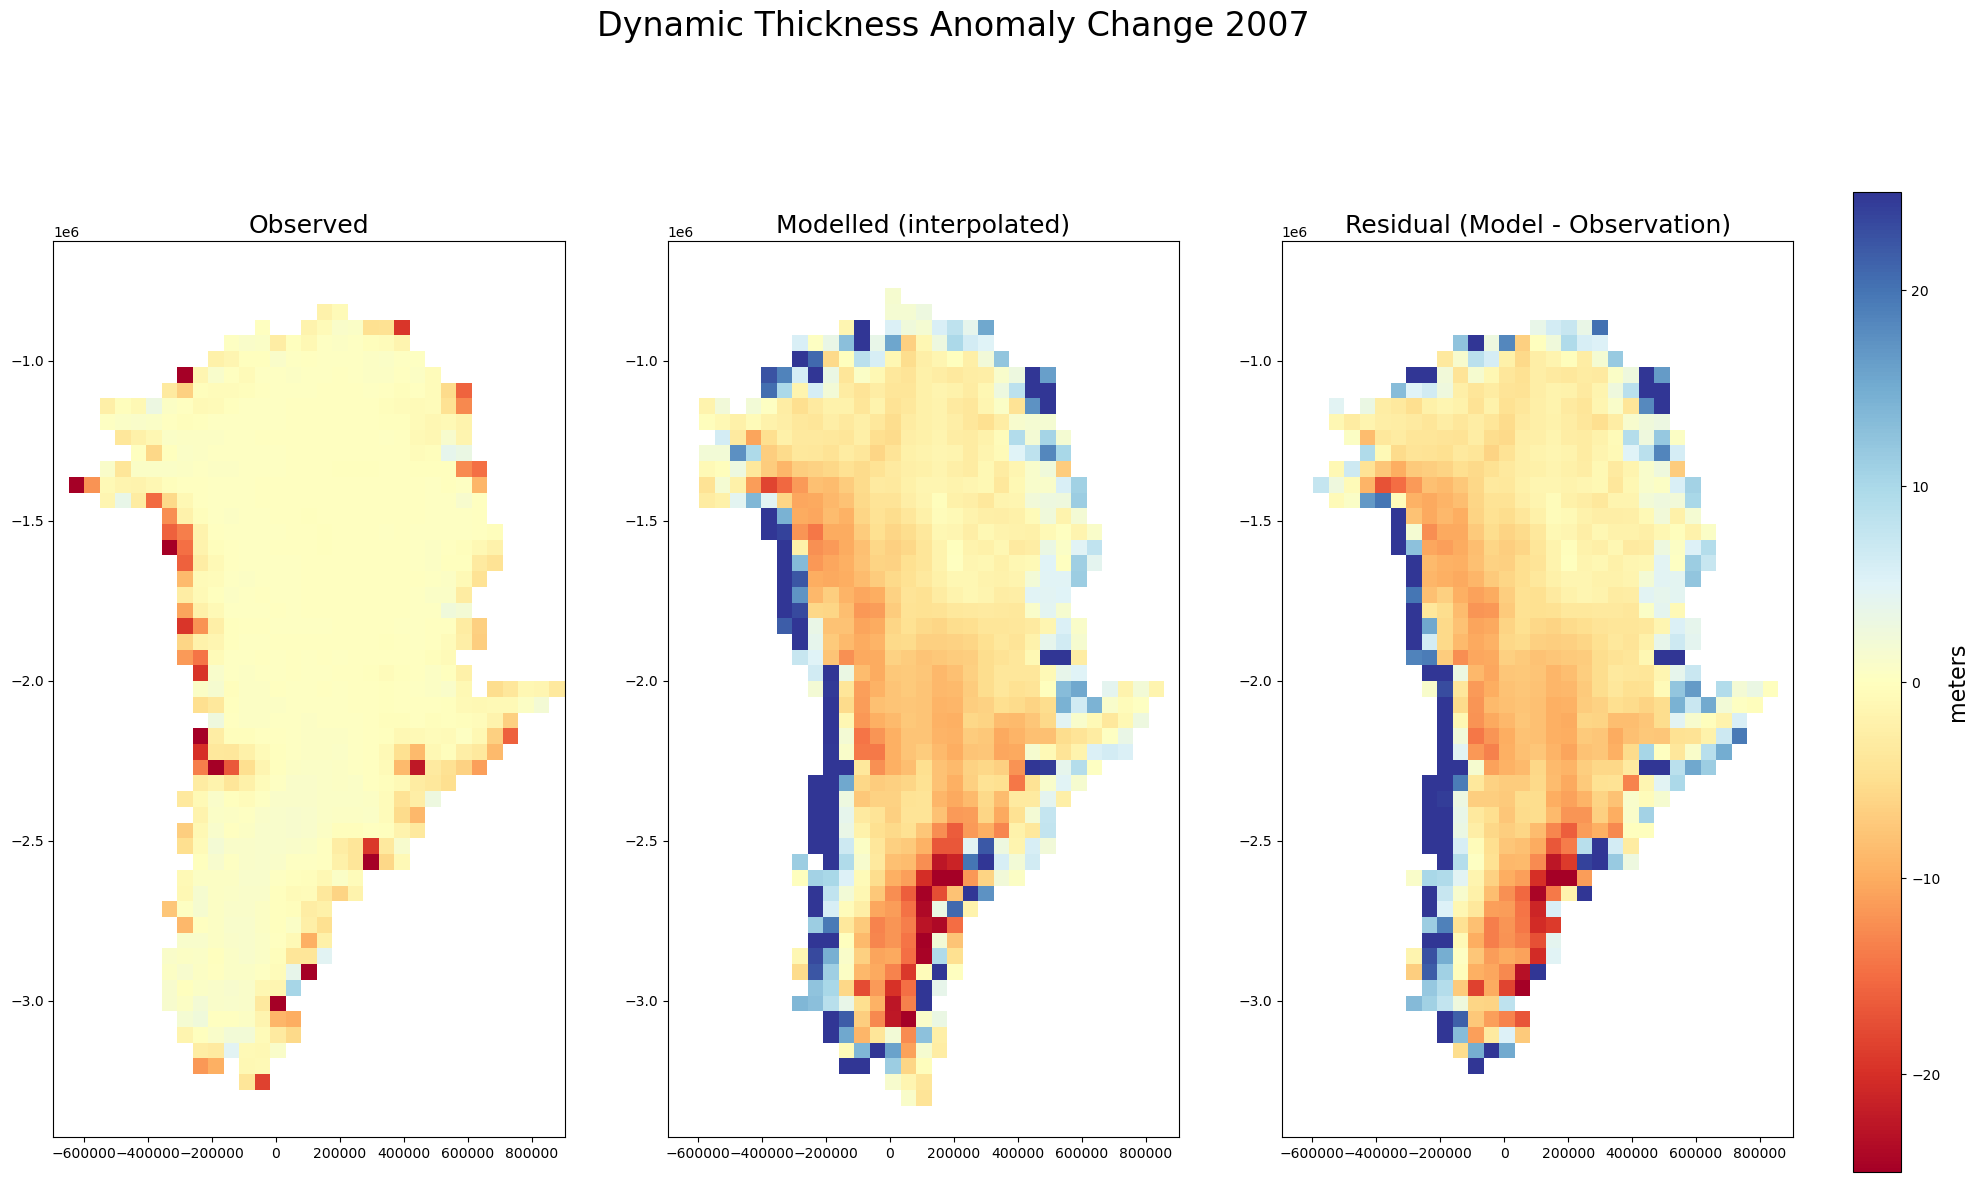

Plotted Results           [####################] 100.0% (4.38484263420105 seconds)
Success
Total time: 14.525423049926758 seconds


In [12]:
t_tot = time.time()
runProcessing()
print("Total time: " + str(time.time() - t_tot) + " seconds")